In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch.nn.functional as F

from src.data.masked_datamodule import MaskedDataModule
from src.config import get_parser

In [2]:
import os
import torch 

from pytorch3d.structures import Pointclouds
import pytorch3d.transforms as T3

from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    look_at_view_transform,
    PointLights,
    PointsRasterizer,
    PointsRasterizationSettings,
)

from src.ShadingPointsRenderer import (
    ShadingCompositor,
    ShadingPointsRenderer,
)
from src.util import make_faces

def vertex_tris(faces):
    res = []
    for vid in range(faces.max()+1):
        vertex_faces = []
        for fid, face in enumerate(faces):
            if vid in face:
                vertex_faces.append(fid)
        res.append(vertex_faces)
    return res

def vertex_tri_maps(faces):
    vts = vertex_tris(faces)
    r, c = len(vts), max([len(x) for  x in vts])
    vert_tri_indices = torch.zeros(r, c, dtype=torch.long)
    vert_tri_weights = torch.zeros(r, c)    
    for r, tris in enumerate(vts):
        weight = 1. / len(tris)
        for c, tri_id in enumerate(tris):
            vert_tri_indices[r, c] = tri_id
            vert_tri_weights[r, c] = weight
    return vert_tri_indices, vert_tri_weights.unsqueeze(dim=-1)[None]

def get_face_normals(vrt, faces):    
    v1 = vrt.index_select(1,faces[:, 1]) - vrt.index_select(1, faces[:, 0])
    v2 = vrt.index_select(1,faces[:, 2]) - vrt.index_select(1, faces[:, 0])
    face_normals = F.normalize(v1.cross(v2), p=2, dim=-1)  # [F, 3]
    return face_normals

def get_vertex_normals(face_normals, vert_tri_indices, vert_tri_weights):
    bs = face_normals.size(0)
    r, c = vert_tri_indices.shape
    fn_group = face_normals.index_select(1, 
        vert_tri_indices.flatten()).reshape(bs, r, c, 3)
    weighted_fn_group = fn_group * vert_tri_weights    
    vertex_normals = weighted_fn_group.sum(dim=-2)
    return F.normalize(vertex_normals, p=2, dim=-1)

class Renderer(torch.nn.Module):
    def __init__(self, opt):    
        super(Renderer, self).__init__()
        self.opt = opt
        self.max_brightness = opt.raster_max_brightness
        # opt.raster_patch_size
        #faces = make_faces(opt.raster_patch_size, opt.raster_patch_size)
        #vert_tri_indices, vert_tri_weights = vertex_tri_maps(faces)     
        trimap =  torch.load(os.path.join(opt.data_dir, 
            'trimap_{}.pth'.format(opt.raster_patch_size)))
        
        self.register_buffer('faces',  trimap['faces'])
        self.register_buffer('vert_tri_indices', trimap['vert_tri_indices'])
        self.register_buffer('vert_tri_weights', trimap['vert_tri_weights'])
    
    def to(self, device):
        new_self = super(Renderer, self).to(device)
        
        R, T = look_at_view_transform(
            self.opt.viewpoint_distance, 
            self.opt.viewpoint_elevation, 
            self.opt.viewpoint_azimuth, 
            device=device)
        cameras = FoVPerspectiveCameras(
            device=device, R=R, T=T)
        raster_settings = PointsRasterizationSettings(
            image_size= self.opt.raster_image_size, 
            radius = self.opt.raster_radius,
            points_per_pixel = self.opt.raster_points_per_pixel,
        )
        rasterizer = PointsRasterizer(
            cameras= cameras, 
            raster_settings=raster_settings
        )
        lights = PointLights(device=device, 
                             location=[self.opt.lights_location])
        compositor = ShadingCompositor(
            device=device, 
            cameras=cameras,
            lights=lights
        )        
        new_self.renderer = ShadingPointsRenderer(
            rasterizer=rasterizer,
            compositor=compositor,
        ) 
        return new_self
    
    def __call__(self, points, normals=None):
        # (b, 3, w, h)
        bs = points.size(0)
        points = points.reshape(bs, 3, -1).permute(0, 2, 1)
        rgb = torch.ones((bs, points.size(1), 4), 
                         device=points.device) * self.max_brightness
        
        if not normals:
            face_normals = get_face_normals(points, self.faces)
            normals = get_vertex_normals(face_normals,
                self.vert_tri_indices, self.vert_tri_weights)
        
#         T = T3.Translate(-points.mean(dim=0)[None]).to(points.device)
#         pt_points = T.transform_points(pt_points)
#         pt_normals = T.transform_normals(pt_normals)

        point_cloud = Pointclouds(points=[points], 
                          normals=[normals],
                          features=[rgb])
        return self.renderer(point_cloud)
    
    
config = get_parser().parse_args(args=[])

# Set the cuda device
device = torch.device("cuda:0")

renderer = Renderer(config).to(device)
renderer

Renderer(
  (renderer): ShadingPointsRenderer(
    (rasterizer): PointsRasterizer(
      (cameras): FoVPerspectiveCameras()
    )
    (compositor): ShadingCompositor(
      (lights): PointLights()
      (materials): Materials()
      (cameras): FoVPerspectiveCameras()
    )
  )
)

In [5]:
opt = config
loaded = torch.load(os.path.join(opt.data_dir, 
                'trimap_{}.pth'.format(opt.raster_patch_size)))
for key in loaded.keys():
    print(key, loaded[key].shape, loaded[key].dtype)

vert_tri_indices torch.Size([65536, 6]) torch.int64
vert_tri_weights torch.Size([1, 65536, 6, 1]) torch.float32
faces torch.Size([1, 130050, 3]) torch.int64


In [6]:
mdm = MaskedDataModule(config)    
mdm.setup()
loader = mdm.train_dataloader()
batch = next(iter(loader))
for key in batch.keys():
    print(key, batch[key].shape)

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/bobi/miniconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/bobi/miniconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/home/bobi/miniconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 73, in default_collate
    return {key: default_collate([d[key] for d in batch]) for key in elem}
  File "/home/bobi/miniconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 73, in <dictcomp>
    return {key: default_collate([d[key] for d in batch]) for key in elem}
  File "/home/bobi/miniconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 55, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [3, 231, 198] at entry 0 and [3, 94, 11] at entry 1


In [5]:
config.raster_patch_size

w = config.raster_patch_size
points = batch['points']
normals = batch['points']

# points = F.interpolate(batch['points'], size=(w, w),
#     mode='bicubic', align_corners=True).to(device)

# normals = F.interpolate(batch['points'], size=(w, w),
#     mode='bicubic', align_corners=True).to(device)

points.shape, normals.shape

(torch.Size([8, 3, 256, 256]), torch.Size([8, 3, 256, 256]))

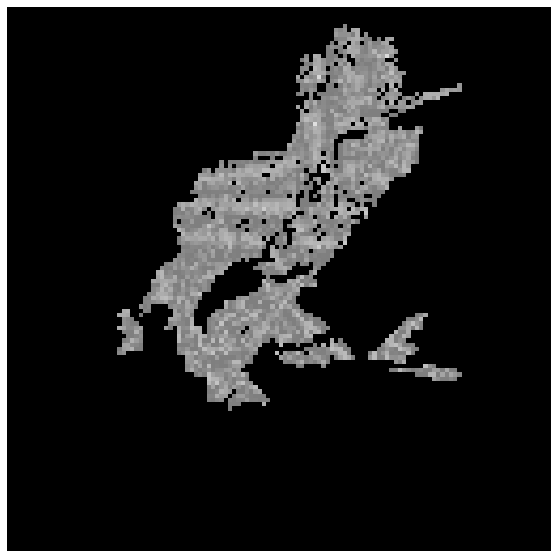

In [16]:
self = renderer

bs = points.size(0)
    
points = points.reshape(bs, 3, -1).permute(0, 2, 1)
normals = normals.reshape(bs, 3, -1).permute(0, 2, 1)
rgb = torch.ones((bs, points.size(1), 3), 
                 device=points.device) * self.max_brightness

# face_normals = get_face_normals(points, self.faces)
# normals = get_vertex_normals(face_normals,
#     self.vert_tri_indices, self.vert_tri_weights)

#         T = T3.Translate(-points.mean(dim=0)[None]).to(points.device)
#         pt_points = T.transform_points(pt_points)
#         pt_normals = T.transform_normals(pt_normals)

point_cloud = Pointclouds(points=points, 
                  normals=normals,
                  features=rgb,)
images = self.renderer(point_cloud)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

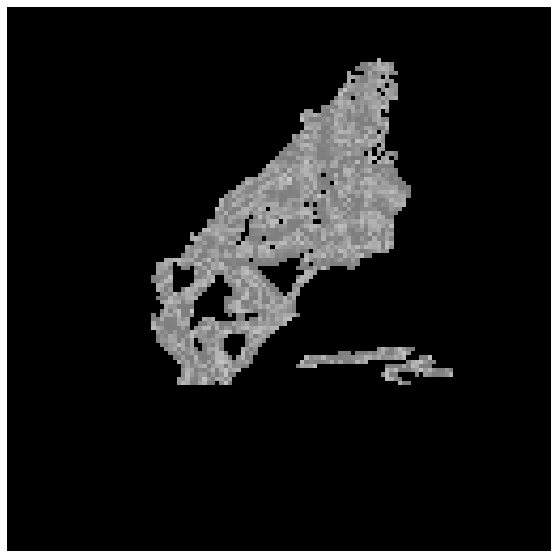

In [19]:
plt.figure(figsize=(10, 10))
plt.imshow(images[3, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

In [11]:
point_cloud = Pointclouds(points=torch.randn(4, 1000, 3),
                          normals=torch.randn(4, 1000, 3),
                          features=torch.randn(4, 1000, 3))

In [13]:
rgb.shape,points.shape, normals.shape

(torch.Size([8, 65536, 3]),
 torch.Size([8, 65536, 3]),
 torch.Size([8, 3, 256, 256]))

In [20]:
images

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],

         ...,

         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000],
          [0.0000